In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
data = pd.read_csv('../data/processed/psi_raw.csv')

In [3]:
wide_data = data.pivot_table(index=['timestamp', 'region'], columns='measure', values='value').reset_index()

In [4]:
from datetime import datetime

def group_timestamp (df):
    dt = (df['timestamp'] / 1000).map(datetime.fromtimestamp)
    df['year'] = dt.map(lambda d: d.year).astype('category')
    df['month'] = dt.map(lambda d: d.month).astype('category')
    df['day'] = dt.map(lambda d: d.day).astype('category')
    df['hour'] = dt.map(lambda d: d.hour).astype('category')
    return df

In [5]:
group_timestamp(wide_data)
wide_data.head()

measure,timestamp,region,co_eight_hour_max,no2_one_hour_max,o3_eight_hour_max,pm10_twenty_four_hourly,pm25_twenty_four_hourly,so2_twenty_four_hourly,year,month,day,hour
0,1454839200000,central,0.45,10.0,59.0,21.0,11.0,3.0,2016,2,7,18
1,1454839200000,east,0.41,4.0,56.0,19.0,11.0,2.0,2016,2,7,18
2,1454839200000,north,0.25,4.0,66.0,22.0,9.0,6.0,2016,2,7,18
3,1454839200000,south,0.45,7.0,46.0,24.0,11.0,2.0,2016,2,7,18
4,1454839200000,west,0.25,5.0,56.0,16.0,8.0,3.0,2016,2,7,18


In [6]:
def segmented_interpolator(x_ref, y_ref):
    def interpolate(x):
        filtered = [ref for ref in x_ref if x >= ref]
        i = len(filtered) - 1
        i = max(0, i)
        i = min(len(x_ref) - 2, i)
        x0 = x_ref[i]
        y0 = y_ref[i]
        x1 = x_ref[i + 1]
        y1 = y_ref[i + 1]
        t = (x - x0) / (x1 - x0)
        return (1 - t) * y0 + t * y1
    return interpolate

In [7]:
PSI_RANGE = [0, 50, 100, 200, 300, 400, 500]
PM25_RANGE = [0, 12, 55, 150, 250, 350, 500]
PM10_RANGE = [0, 50, 150, 350, 420, 500, 600]
SO2_RANGE = [0, 80, 365, 800, 1600, 2100, 2620]
CO_RANGE = [0, 5.0, 10.0, 17.0, 34.0, 46.0, 57.5]
O3_RANGE = [0, 118, 157, 235, 785, 980, 1180]
NO2_RANGE = [0, 0, 0, 1130, 2260, 3000, 3750]

PM25_interpolator = segmented_interpolator(PM25_RANGE, PSI_RANGE)
PM10_interpolator = segmented_interpolator(PM10_RANGE, PSI_RANGE)
SO2_interpolator = segmented_interpolator(SO2_RANGE, PSI_RANGE)
CO_interpolator = segmented_interpolator(CO_RANGE, PSI_RANGE)
O3_interpolator = segmented_interpolator(O3_RANGE, PSI_RANGE)
NO2_interpolator = segmented_interpolator(NO2_RANGE, PSI_RANGE)

def calculate_index(df):
    SUB_INDICES = ['PM25_index', 'PM10_index', 'SO2_index', 'CO_index', 'O3_index', 'NO2_index']
    def match(d):
        for index in SUB_INDICES:
            if d['PSI'] == d[index]:
                return index
    
    df['PM25_index'] = df['pm25_twenty_four_hourly'].map(PM25_interpolator)
    df['PM10_index'] = df['pm10_twenty_four_hourly'].map(PM10_interpolator)
    df['SO2_index'] = df['so2_twenty_four_hourly'].map(SO2_interpolator)
    df['CO_index'] = df['co_eight_hour_max'].map(CO_interpolator)
    df['O3_index'] = df['o3_eight_hour_max'].map(O3_interpolator)
    df['NO2_index'] = df['no2_one_hour_max'].map(lambda x: NO2_interpolator(x) if x >= 1130 else 0)
    df['PSI'] = df.apply(lambda d: max(d['PM25_index'], d['PM10_index'], d['SO2_index'], d['CO_index'], d['O3_index'], d['NO2_index']), axis=1)
    df['primary'] = df.apply(match, axis=1)
    return df

In [8]:
calculate_index(wide_data)
wide_data.head()

measure,timestamp,region,co_eight_hour_max,no2_one_hour_max,o3_eight_hour_max,pm10_twenty_four_hourly,pm25_twenty_four_hourly,so2_twenty_four_hourly,year,month,day,hour,PM25_index,PM10_index,SO2_index,CO_index,O3_index,NO2_index,PSI,primary
0,1454839200000,central,0.45,10.0,59.0,21.0,11.0,3.0,2016,2,7,18,45.833333,21.0,1.875,4.5,25.000000,0,45.833333,PM25_index
1,1454839200000,east,0.41,4.0,56.0,19.0,11.0,2.0,2016,2,7,18,45.833333,19.0,1.250,4.1,23.728814,0,45.833333,PM25_index
2,1454839200000,north,0.25,4.0,66.0,22.0,9.0,6.0,2016,2,7,18,37.500000,22.0,3.750,2.5,27.966102,0,37.500000,PM25_index
3,1454839200000,south,0.45,7.0,46.0,24.0,11.0,2.0,2016,2,7,18,45.833333,24.0,1.250,4.5,19.491525,0,45.833333,PM25_index
4,1454839200000,west,0.25,5.0,56.0,16.0,8.0,3.0,2016,2,7,18,33.333333,16.0,1.875,2.5,23.728814,0,33.333333,PM25_index


In [9]:
wide_data.groupby('primary')['timestamp'].count()

primary
CO_index           8
O3_index         320
PM10_index       178
PM25_index    150356
SO2_index        383
Name: timestamp, dtype: int64

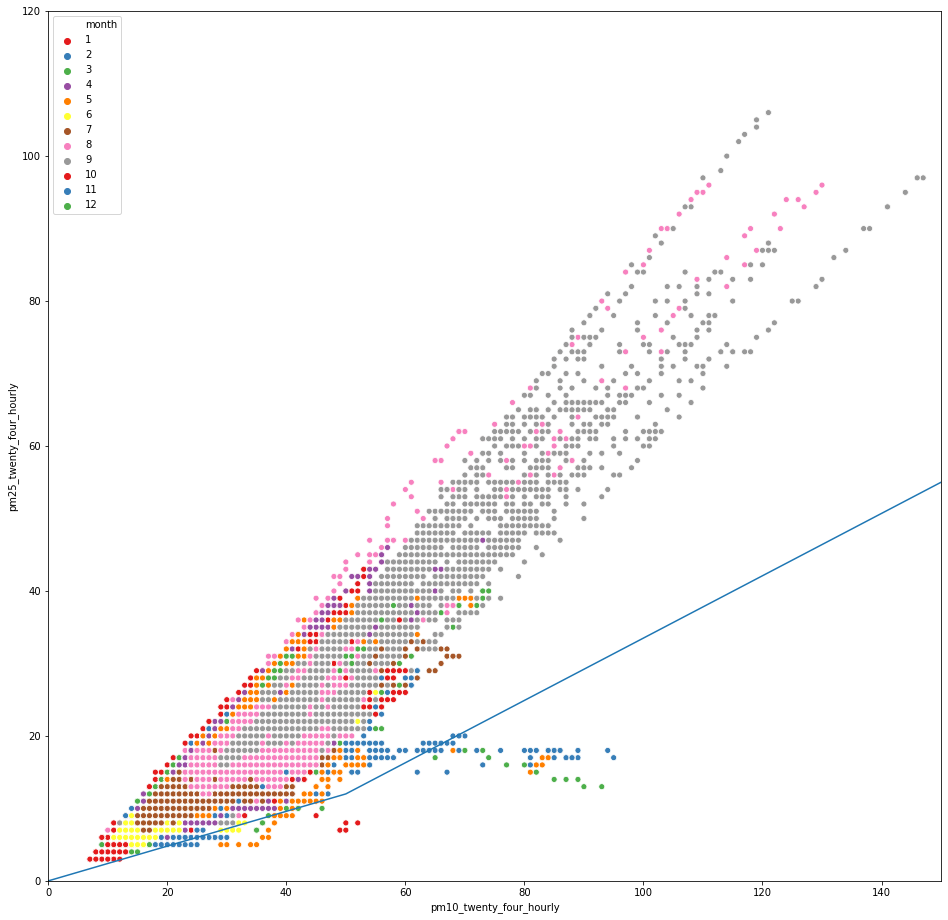

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 16)
ax.set_xlim(left=0, right=150)
ax.set_ylim(bottom=0, top=120)
sns.scatterplot(x='pm10_twenty_four_hourly', y='pm25_twenty_four_hourly', hue='month',
                data=wide_data, palette=sns.color_palette('Set1', 12), ax=ax)
sns.lineplot(x=PM10_RANGE, y=PM25_RANGE, ax=ax)